## Import

In [4]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from tqdm import tqdm

from functions_IDEAS import compute_ID

## functions

In [3]:
def assign_label(cluster):
    cluster = str(cluster)
    if cluster in cluster_fibro:
        return 'fibro'
    elif cluster in cluster_partial:
        return 'partial'
    elif cluster in cluster_reprogramming:
        return 'reprogramming'
    else:
        return 'other'

In [16]:
def add_local_ID_to_adata(Adata, ID_dataframe, N_neigh=0):

    if N_neigh==0 : 
        N_neigh = 0.1 * len(Adata)

    if f'local_ID_{N_neigh}' not in Adata.obs.columns:
        Adata.obs[f'local_ID_{N_neigh}'] = pd.NA 

    index = [item[0] for item in ID_dataframe.index]
    for barcode,id_val in zip(index, ID_dataframe.ID.values):
        Adata.obs.loc[Adata.obs_names == barcode, f'local_ID_{N_neigh}'] = id_val

    Adata.obs[f'local_ID_{N_neigh}'] = Adata.obs[f'local_ID_{N_neigh}'].replace({pd.NA: np.nan}).astype(float)

    return Adata

In [5]:
def add_pseudotime_fibro(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmin(Adata_hv.obsm['X_diffmap'][:, 1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [6]:
def add_pseudotime_partial(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmin(Adata_hv.obsm['X_diffmap'][:,1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [7]:
def add_pseudotime_rep(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmax(Adata_hv.obsm['X_diffmap'][:,1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [8]:
def plot_clusters_boxplot(adata_ivf, adata_nt):

    adata_ivf.obs["local_ID"] = pd.to_numeric(adata_ivf.obs["local_ID"], errors="coerce")
    adata_nt.obs["local_ID"] = pd.to_numeric(adata_nt.obs["local_ID"], errors="coerce")

    adata_ivf.obs["Dataset"] = "IVF"
    adata_nt.obs["Dataset"] = "NT"

    combined_df = pd.concat([adata_ivf.obs, adata_nt.obs])
    clusters = sorted(combined_df["seurat_clusters"].unique())
    colors = sns.color_palette("tab10", 10)

    fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)  

    for i, cluster in enumerate(clusters):
        row, col = divmod(i, 5)  
        
   
        cluster_data = combined_df[combined_df["seurat_clusters"] == cluster]
        cluster_color = [colors[i]] * 2  

        sns.boxplot(data=cluster_data, x="Dataset", y="local_ID", ax=axes[row, col], palette=cluster_color)
        
        axes[row, col].set_title(f"Cluster {cluster}")
        axes[row, col].set_xlabel("")
        axes[row, col].set_ylabel("Local ID" if col == 0 else "")  
        axes[row, col].yaxis.grid(True)  

    plt.tight_layout()
    plt.show()


In [9]:
def create_layer_df(adata, n_neighbors):
    layers = ['inner', 'outer']
    data = [(adata[adata.obs.layer == layer].obs[f'local_ID_{n_neighbors}'].values, layer) for layer in layers]
    return pd.DataFrame({
        'Value': [val for values, _ in data for val in values],
        'Layer': [layer for values, layer in data for _ in values]
    })

In [10]:
def add_significance_bar(ax, pval, x1, x2, y_max, h=3, fontsize=12):
    y = y_max + h 
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
    if pval < 0.001:
        significance = '***'
    elif pval < 0.01:
        significance = '**'
    elif pval < 0.05:
        significance = '*'
    else:
        significance = 'ns'
    ax.text((x1 + x2) / 2, y + h, significance, ha='center', fontsize=fontsize)

## Tran

In [11]:
# upload preprocessed data (with raw counts in the adata.X)
adata_fbs=sc.read('../Datasets/FBS_IDEAS.h5ad')
adata_a2s=sc.read('../Datasets/A2S_IDEAS.h5ad')

### FBS

In [15]:
# compute local ID for each cell
n_neighbors = 600
IDs_fbs = compute_ID(adata_fbs, method='local_2nn', n_samples = len(adata_fbs), n_neighbors = n_neighbors, full_output = True, id_score = True)
adata_fbs = add_local_ID_to_adata(adata_fbs, IDs_fbs, n_neighbors)


Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [29:06<00:00, 1746.32s/it]


NameError: name 'add_local_ID_to_adata' is not defined

  0%|          | 2/3435 [50:49<1453:50:40, 1524.57s/it]


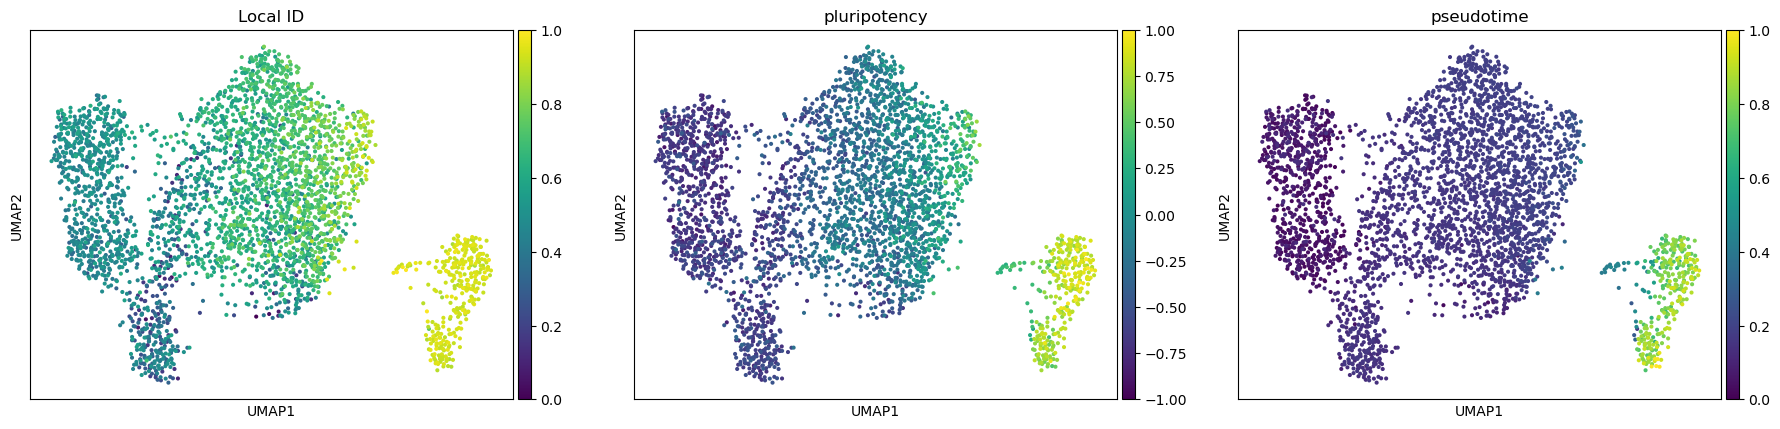

In [18]:

sc.pl.umap(adata_fbs, color=[f'local_ID_{n_neighbors}', 'pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)

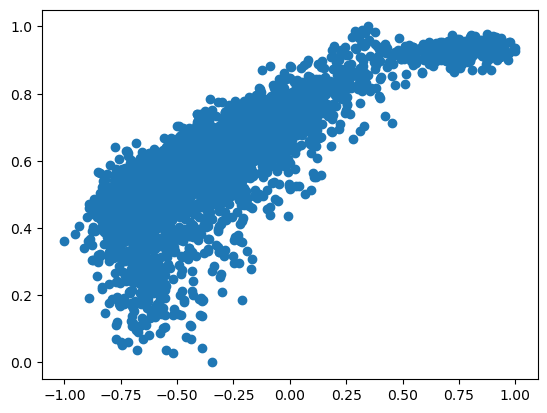

In [20]:
plt.scatter(adata_fbs.obs.pluripotency, adata_fbs.obs.local_ID_600)

In [26]:
# save results

#adata_fbs.write('../Datasets/FBS_to_plot.h5ad')

### A2S

In [21]:
# compute local ID for each cell
n_neighbors = 600
IDs_a2s = compute_ID(adata_a2s, method='local_2nn', n_samples = len(adata_a2s), n_neighbors = n_neighbors, full_output = True)
adata_a2s = add_local_ID_to_adata(adata_a2s, IDs_a2s, n_neighbors)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [21:15<00:00, 1275.14s/it]


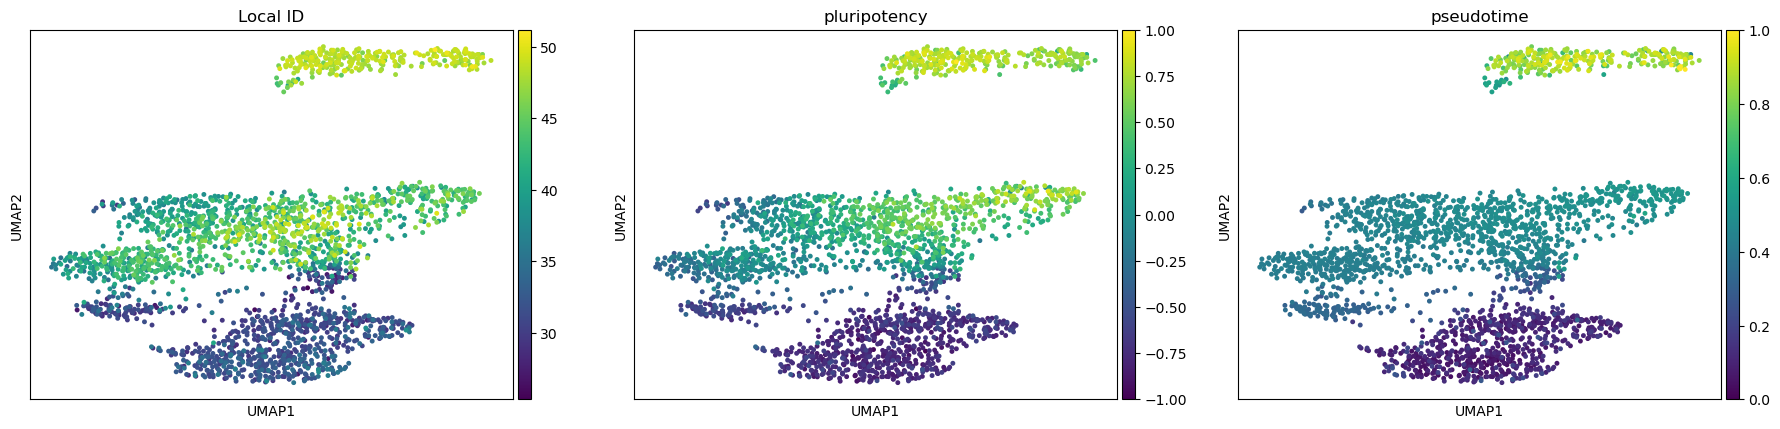

In [22]:
sc.pl.umap(adata_a2s, color=[f'local_ID_{n_neighbors}', 'pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)

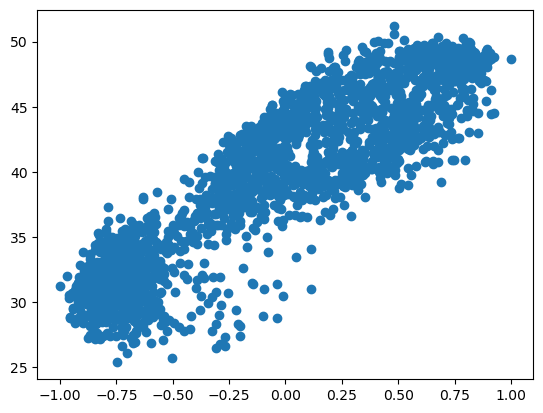

In [23]:
plt.scatter(adata_a2s.obs.pluripotency, adata_a2s.obs.local_ID_600)

In [28]:
#save results 

#adata_a2s.write('../Datasets/A2S_to_plot.h5ad')

## Nair 

In [87]:
# This is the code I ran to obtain the adata_nair_localID. Since it takes a long time, I saved it in Nair_local_ID.h5ad and use that for the following analysis.
'''
adata = sc.read('../Datasets/Nair.h5ad')

n_samples = 30000
n_neighbors = 600
IDs_nair = compute_ID(adata, method='local_2nn', n_samples = n_samples, n_neighbors = n_neighbors, full_output = True)
adata_nair_localID = add_local_ID_to_adata(adata, IDs_nair)'
'''

In [61]:
adata_nair_localID = sc.read('../Datasets/Nair_local_ID.h5ad')

In [62]:
#pseudotime 

# Divide the dataset in fibro, partial and reprogramming
cluster_fibro = ['1', '3', '4', '5']
cluster_partial = ['7', '9', '10']
cluster_reprogramming = ['8', '11', '12', '13', '14'] #cluster 15 is not included in the analysis 

adata_nair_localID.obs['trajectory'] = adata_nair_localID.obs['cluster'].apply(assign_label)

adata_fibro = adata_nair_localID[adata_nair_localID.obs.trajectory == 'fibro']
adata_partial = adata_nair_localID[adata_nair_localID.obs.trajectory == 'partial']
adata_rep = adata_nair_localID[adata_nair_localID.obs.trajectory == 'reprogramming']

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


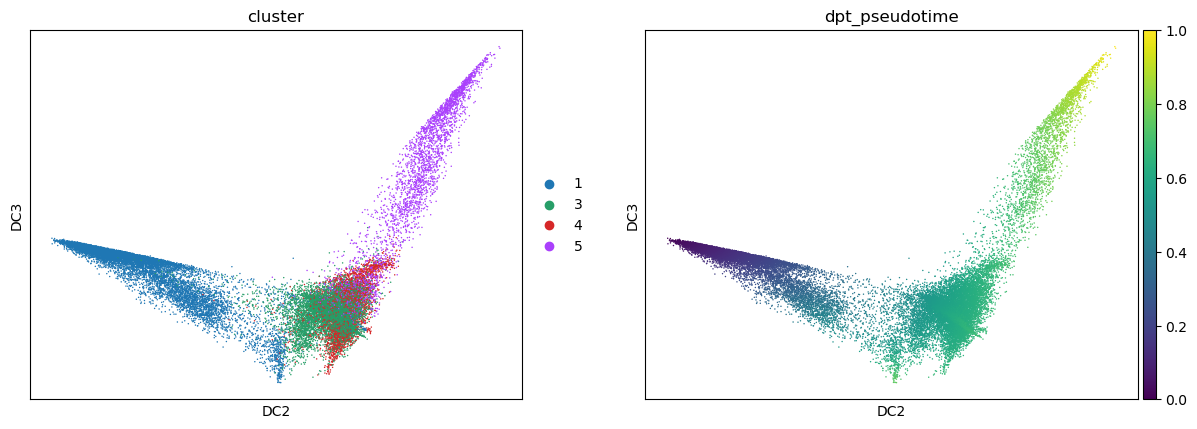

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

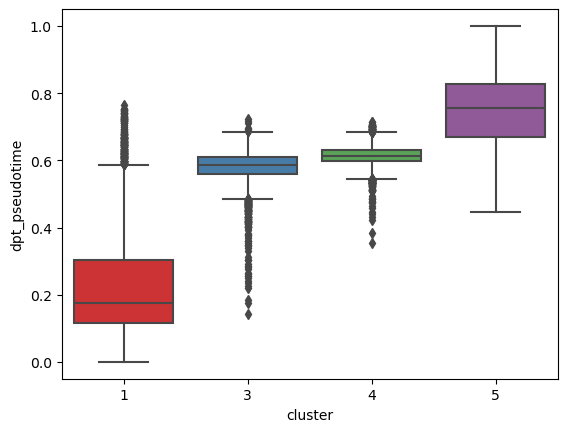

In [63]:
adata_fibro = add_pseudotime_fibro(adata_fibro)
sc.pl.diffmap(adata_fibro, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)]) #visualize pseudotime
sns.boxplot(data=adata_fibro.obs, x="cluster", y="dpt_pseudotime", palette='Set1') #check the correct ordering of clusters with psudotime 

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


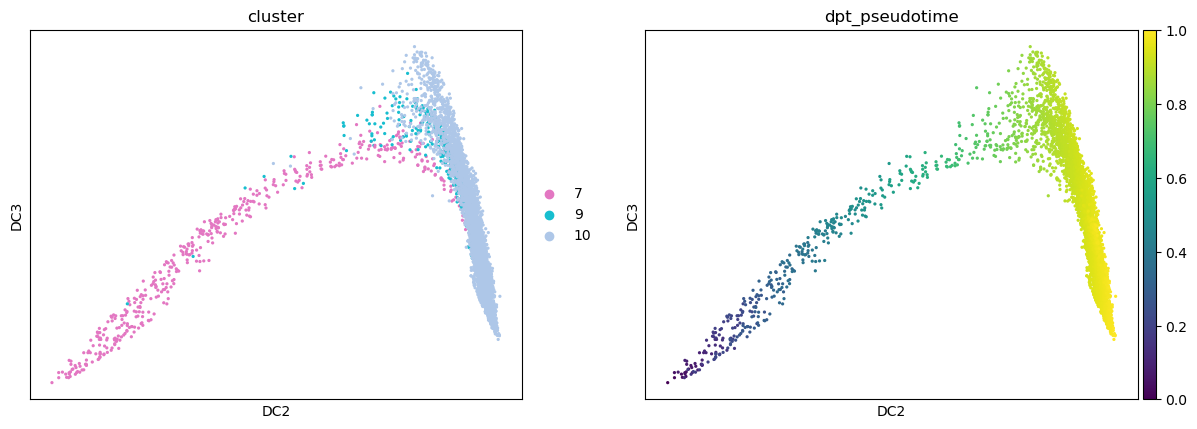

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

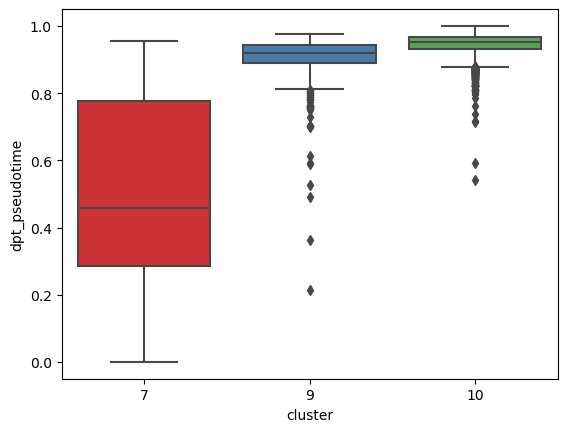

In [64]:
adata_partial = add_pseudotime_partial(adata_partial)
sc.pl.diffmap(adata_partial, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)])
sns.boxplot(data=adata_partial.obs, x="cluster", y="dpt_pseudotime", palette='Set1')

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


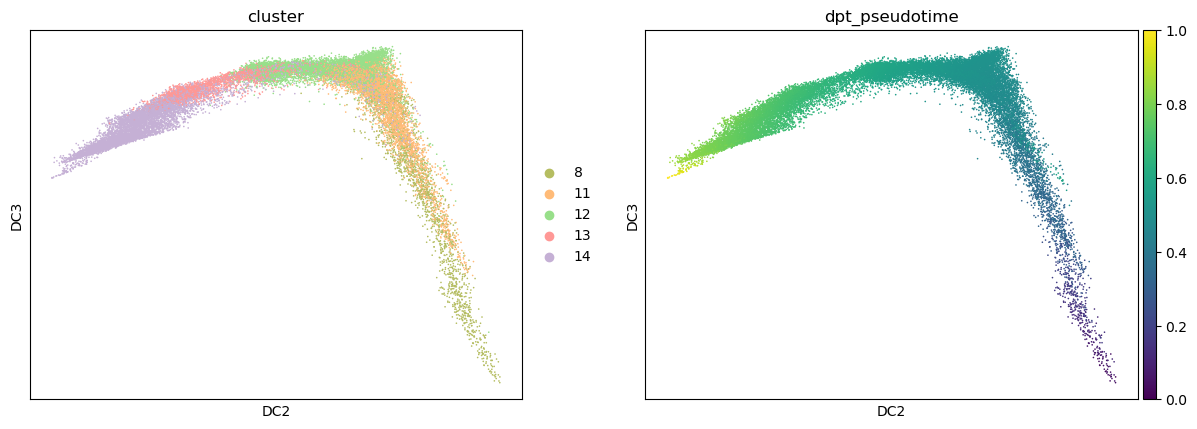

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

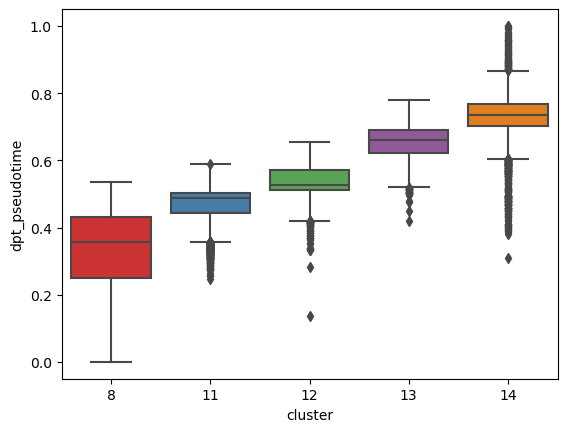

In [65]:
adata_rep = add_pseudotime_rep(adata_rep)
sc.pl.diffmap(adata_rep, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)])
sns.boxplot(data=adata_rep.obs, x="cluster", y="dpt_pseudotime", palette='Set1')

In [ ]:
# save results ready to plot
#adata_rep.write('../Datasets/Nair_REP_to_plot.h5ad')
#adata_fibro.write('../Datasets/Nair_FIBRO_to_plot.h5ad')
#adata_partial.write('../Datasets/Nair_PARTIAL_to_plot.h5ad')


## Xenopus

In [5]:
adata_xen = sc.read('../Datasets/xenopus_correct.h5ad')

In [6]:
adata_xen

AnnData object with n_obs × n_vars = 3364 × 31179
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'isnt', 'integrated_snn_res.0.5', 'seurat_clusters'
    var: 'features'
    uns: 'isnt_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

 22%|██▏       | 766/3435 [14:20:41<49:58:54, 67.42s/it]
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


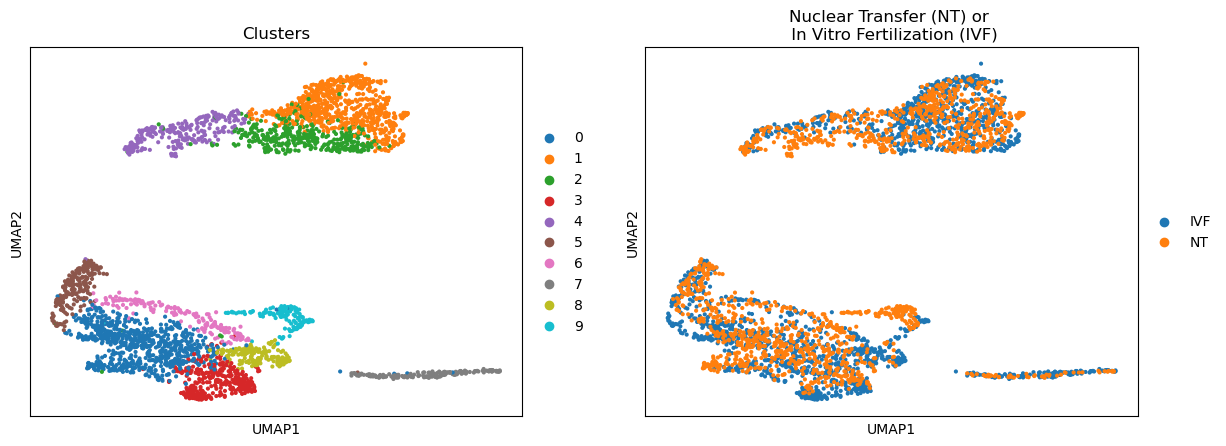

In [31]:
# visualize cluster division and nuclear transfer (NT) vs in vitro fertilization (IVF)
sc.pl.umap(adata_xen, color=['seurat_clusters', 'isnt'], title = ['Clusters', 'Nuclear Transfer (NT) or \n In Vitro Fertilization (IVF)'], alpha=1.)

In [32]:
#Select the experiment with a higher number of cells

df = pd.DataFrame({'batch': adata_xen.obs.stim, 'condition': adata_xen.obs.isnt})
contingency_table = pd.crosstab(df['batch'], df['condition'])
print(contingency_table)

adata_ivf = adata_xen[adata_xen.obs.stim == 'SIGAH5']  #'IVF'
adata_nt = adata_xen[adata_xen.obs.stim == 'SIGAH12']  #'NT'

condition   IVF    NT
batch                
SIGAA2      559     0
SIGAB2        0   495
SIGAH5     1267     0
SIGAH12       0  1043


In [29]:
1267+559

1826

In [30]:
495+1043

1538

In [33]:
# run local ID analysis separately for NT and IVF
n_neighbors = 100
IDs_ivf = compute_ID(adata_ivf, method='local_2nn', n_samples = len(adata_ivf), n_neighbors = n_neighbors, full_output = True)
IDs_nt = compute_ID(adata_nt, method='local_2nn', n_samples = len(adata_nt), n_neighbors = n_neighbors, full_output = True)
adata_ivf = add_local_ID_to_adata(adata_ivf,IDs_ivf, n_neighbors)
adata_nt = add_local_ID_to_adata(adata_nt,IDs_nt, n_neighbors)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [04:11<00:00, 251.89s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30907/2734031154.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs[f'local_ID_{N_neigh}'] = pd.NA
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30907/2734031154.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs[f'local_ID_{N_neigh}'] = pd.NA


In [35]:
#adata_ivf.write('../Datasets/Xenopus_IVF_to_plot.h5ad')
#adata_nt.write('../Datasets/Xenopus_NT_to_plot.h5ad')

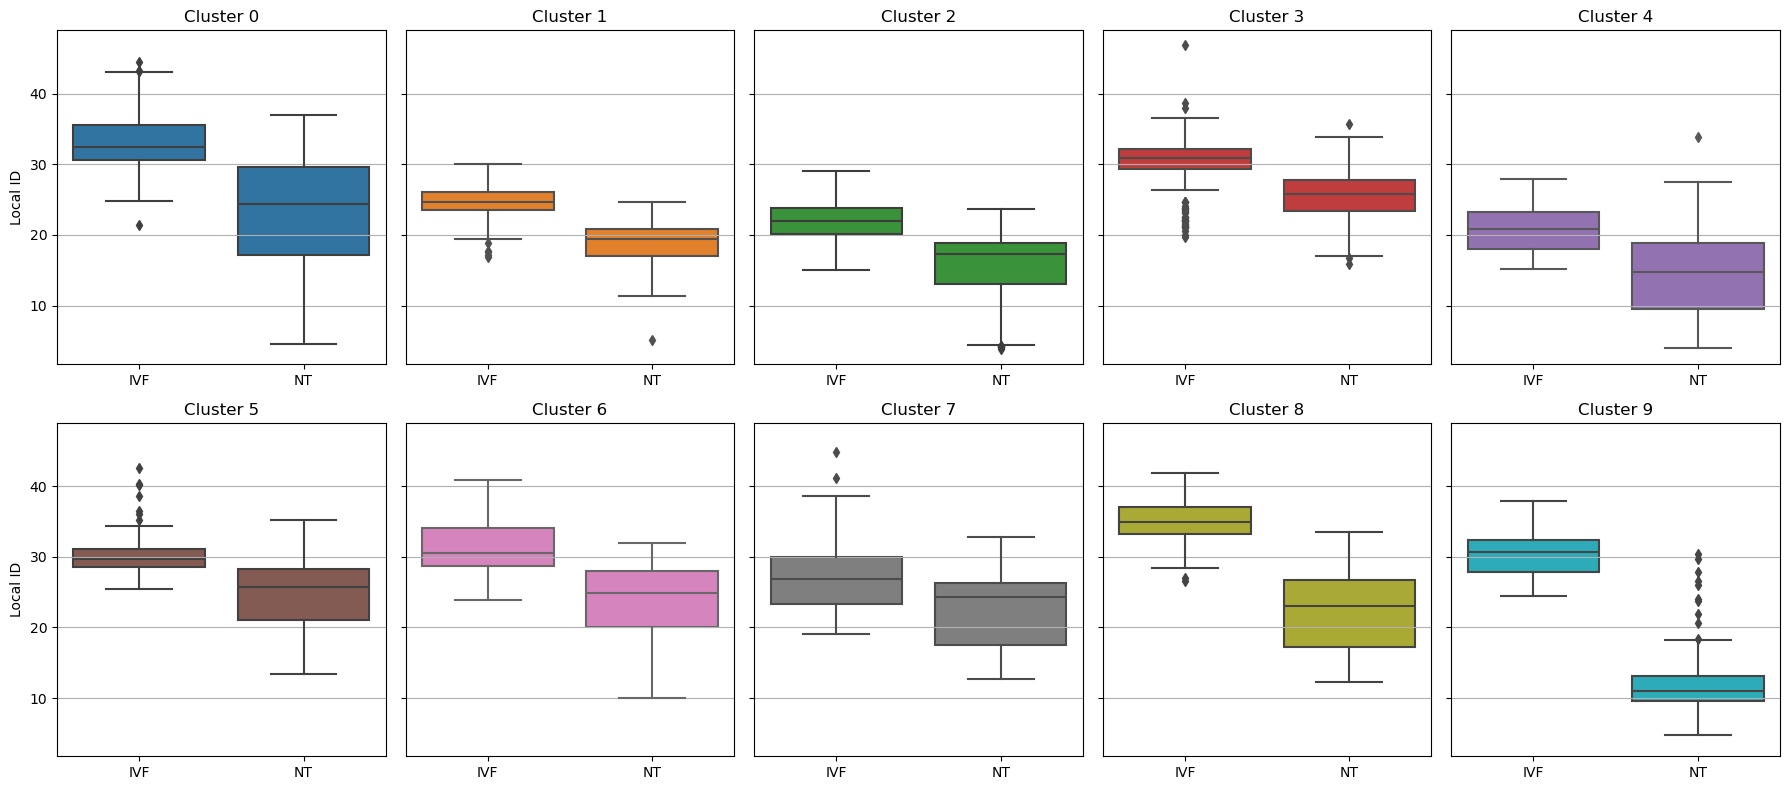

In [139]:
#plot difference in the ID for each cluster
plot_clusters_boxplot(adata_ivf, adata_nt)